In [1]:
import torch
import torch.nn as nn
import torch.utils.checkpoint as checkpoint
from einops import rearrange
from timm.models.layers import DropPath, to_2tuple, trunc_normal_

In [2]:
class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x

In [3]:
def window_partition(x, window_size):
    """
    Args:
        x: (B, L, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, C)
    """
    B, L, C = x.shape
    x = x.view(B, L // window_size, window_size, C)
    windows = x.permute(0, 1, 2, 3).contiguous().view(-1, window_size, C)
    return windows

In [4]:
def window_reverse(windows, window_size, L):
    """
    Args:
        windows: (num_windows*B, window_size, C)
        window_size (int): Window size
        L (int): Length of sequence

    Returns:
        x: (B, L, C)
    """
    B = int(windows.shape[0] / (L / window_size))
    x = windows.view(B, L // window_size, window_size, -1)
    x = x.permute(0, 1, 2, 3).contiguous().view(B, L, -1)
    return x

In [5]:
class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        attn = attn

        if mask is not None:
            pass
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops

In [6]:
class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=22, patch_size=2, in_chans=20, embed_dim=96, norm_layer=None):
        super().__init__()
        patches_resolution = img_size // patch_size
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        self.proj = nn.Conv1d(in_chans, embed_dim, kernel_size=patch_size, stride=patch_size)
        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        B, C, L = x.shape
        # FIXME look at relaxing size constraints
        assert L == self.img_size, \
            f"Input image size ({L}) doesn't match model ({self.img_size})."
        x = self.proj(x).flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        Ho, Wo = self.patches_resolution
        flops = Ho * Wo * self.embed_dim * self.in_chans * (self.patch_size[0] * self.patch_size[1])
        if self.norm is not None:
            flops += Ho * Wo * self.embed_dim
        return flops

In [7]:
class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=12, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if self.input_resolution <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = self.input_resolution
            
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=self.window_size, num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            # calculate attention mask for SW-MSA
            attn_mask = None
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def forward(self, x):
        H = self.input_resolution
        B, L, C = x.shape
        assert L == H, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, L, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = x
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, C
        x_windows = x_windows.view(-1, self.window_size, C)  # nW*B, window_size, C

        # W-MSA/SW-MSA
        attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, L)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = shifted_x
        else:
            x = shifted_x
        x = x.view(B, L, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H = self.input_resolution
        # norm1
        flops += self.dim * H 
        # W-MSA/SW-MSA
        nW = H / self.window_size
        flops += nW * self.attn.flops(self.window_size)
        # mlp
        flops += 2 * H * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H
        return flops

In [8]:
class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.norm = norm_layer(2 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H = self.input_resolution
        B, L, C = x.shape
        assert L == H, "input feature has wrong size"
        assert H % 2 == 0, f"x size ({H}) are not even."

        x = x.view(B, L, C)

        x0 = x[:, 0::2, :]  # B L/2 C
        x1 = x[:, 1::2, :]  # B L/2 C
        x = torch.cat([x0, x1], -1)  # B L/2 2*C
        x = x.view(B, -1, 2 * C)  # B L/2 2*C

        x = self.norm(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H = self.input_resolution
        flops = H * self.dim
        flops += (H // 2) * 4 * self.dim * 2 * self.dim
        return flops

In [9]:
class PatchExpand(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=2, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.expand = nn.Linear(dim, dim, bias=False) if dim_scale==2 else nn.Identity()
        self.norm = norm_layer(dim // dim_scale)

    def forward(self, x):
        """
        x: B, L, C
        """
        H = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H, "input feature has wrong size"

        x = x.view(B, L, C)
        x = rearrange(x, 'b l (p1 c)-> b (l p1) c', p1=2, c=C//2)
        x = x.view(B,-1,C//2)
        x= self.norm(x)

        return x

In [10]:
class FinalPatchExpand_X4(nn.Module):
    def __init__(self, input_resolution, dim, dim_scale=4, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.dim_scale = dim_scale
        self.expand = nn.Linear(dim, 2*dim, bias=False)
        self.output_dim = dim 
        self.norm = norm_layer(self.output_dim)

    def forward(self, x):
        """
        x: B, L, C
        """
        H = self.input_resolution
        x = self.expand(x)
        B, L, C = x.shape
        assert L == H, "input feature has wrong size"

        x = x.view(B, L, C)
        x = rearrange(x, 'b l (p1 c)-> b (l p1) c', p1=self.dim_scale, c=C//(self.dim_scale))
        x = x.view(B,-1,self.output_dim)
        x= self.norm(x)

        return x

In [11]:
class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


In [12]:
class BasicLayer_up(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        upsample (nn.Module | None, optional): upsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, upsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if upsample is not None:
            self.upsample = PatchExpand(input_resolution, dim=dim, dim_scale=2, norm_layer=norm_layer)
        else:
            self.upsample = None

    def forward(self, x):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x)
            else:
                x = blk(x)
        if self.upsample is not None:
            x = self.upsample(x)
        return x

In [13]:
class SwinTransformerSys(nn.Module):
    r""" Swin Transformer
        A PyTorch impl of : `Swin Transformer: Hierarchical Vision Transformer using Shifted Windows`  -
          https://arxiv.org/pdf/2103.14030

    Args:
        img_size (int | tuple(int)): Input image size. Default 224
        patch_size (int | tuple(int)): Patch size. Default: 4
        in_chans (int): Number of input image channels. Default: 3
        num_classes (int): Number of classes for classification head. Default: 1000
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
    """

    def __init__(self, img_size=16, patch_size=2, in_chans=22, num_classes=22,
                 embed_dim=96, depths=[2, 2, 2, 2], depths_decoder=[1, 2, 2, 2], num_heads=[3, 6, 12, 24],
                 window_size=12, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, final_upsample="expand_first", **kwargs):
        super().__init__()

        print("SwinTransformerSys expand initial----depths:{};depths_decoder:{};drop_path_rate:{};num_classes:{}".format(depths,
        depths_decoder,drop_path_rate,num_classes))

        self.num_classes = num_classes
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = int(embed_dim * 2 ** (self.num_layers - 1))
        self.num_features_up = int(embed_dim * 2)
        self.mlp_ratio = mlp_ratio
        self.final_upsample = final_upsample

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=in_chans, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build encoder and bottleneck layers
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = BasicLayer(dim=int(embed_dim * 2 ** i_layer),
                               input_resolution=(patches_resolution // (2 ** i_layer)),
                               depth=depths[i_layer],
                               num_heads=num_heads[i_layer],
                               window_size=window_size,
                               mlp_ratio=self.mlp_ratio,
                               qkv_bias=qkv_bias, qk_scale=qk_scale,
                               drop=drop_rate, attn_drop=attn_drop_rate,
                               drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],
                               norm_layer=norm_layer,
                               downsample=PatchMerging if (i_layer < self.num_layers - 1) else None,
                               use_checkpoint=use_checkpoint)
            self.layers.append(layer)
        
        # build decoder layers
        self.layers_up = nn.ModuleList()
        self.concat_back_dim = nn.ModuleList()
        for i_layer in range(self.num_layers):
            concat_linear = nn.Linear(2*int(embed_dim*2**(self.num_layers-1-i_layer)),
            int(embed_dim*2**(self.num_layers-1-i_layer))) if i_layer > 0 else nn.Identity()
            if i_layer ==0 :
                layer_up = PatchExpand(input_resolution=(patches_resolution // (2 ** (self.num_layers-1-i_layer))), 
                                       dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)), dim_scale=2, norm_layer=norm_layer)
            else:
                layer_up = BasicLayer_up(dim=int(embed_dim * 2 ** (self.num_layers-1-i_layer)),
                                input_resolution=(patches_resolution // (2 ** (self.num_layers-1-i_layer))),
                                depth=depths[(self.num_layers-1-i_layer)],
                                num_heads=num_heads[(self.num_layers-1-i_layer)],
                                window_size=window_size,
                                mlp_ratio=self.mlp_ratio,
                                qkv_bias=qkv_bias, qk_scale=qk_scale,
                                drop=drop_rate, attn_drop=attn_drop_rate,
                                drop_path=dpr[sum(depths[:(self.num_layers-1-i_layer)]):sum(depths[:(self.num_layers-1-i_layer) + 1])],
                                norm_layer=norm_layer,
                                upsample=PatchExpand if (i_layer < self.num_layers - 1) else None,
                                use_checkpoint=use_checkpoint)
            self.layers_up.append(layer_up)
            self.concat_back_dim.append(concat_linear)

        self.norm = norm_layer(self.num_features)
        self.norm_up= norm_layer(self.embed_dim)

        if self.final_upsample == "expand_first":
            print("---final upsample expand_first---")
            self.up = FinalPatchExpand_X4(input_resolution=(img_size//patch_size),dim_scale=4,dim=embed_dim)
            self.output = nn.Conv1d(in_channels=embed_dim,out_channels=self.num_classes,kernel_size=1,bias=False)

        self.apply(self._init_weights)
        
        self.flatten = nn.Flatten()
        self.final_layer = nn.Linear(num_classes*16, 1)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    #Encoder and Bottleneck
    def forward_features(self, x):
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)
        x_downsample = []

        for layer in self.layers:
            x_downsample.append(x)
            x = layer(x)

        x = self.norm(x)  # B L C
  
        return x, x_downsample

    #Dencoder and Skip connection
    def forward_up_features(self, x, x_downsample):
        for inx, layer_up in enumerate(self.layers_up):
            if inx == 0:
                x = layer_up(x)
            else:
                x = torch.cat([x,x_downsample[3-inx]],-1)
                x = self.concat_back_dim[inx](x)
                x = layer_up(x)

        x = self.norm_up(x)  # B L C
  
        return x

    def up_x4(self, x):
        H = self.patches_resolution
        B, L, C = x.shape
        assert L == H, "input features has wrong size"

        if self.final_upsample=="expand_first":
            x = self.up(x)
            x = x.view(B,2*L,-1)
            x = x.permute(0,2,1) #B,C,L
            x = self.output(x)
            
        return x

    def forward(self, x):
        x, x_downsample = self.forward_features(x)
        x = self.forward_up_features(x,x_downsample)
        x = self.up_x4(x)
        
        x = self.flatten(x)
        x = self.final_layer(x)

        return x

    def flops(self):
        flops = 0
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += self.num_features * self.patches_resolution // (2 ** self.num_layers)
        flops += self.num_features * self.num_classes
        return flops

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn((5, 22, 16)).to(device)
model = SwinTransformerSys().to(device)

SwinTransformerSys expand initial----depths:[2, 2, 2, 2];depths_decoder:[1, 2, 2, 2];drop_path_rate:0.1;num_classes:22
---final upsample expand_first---


In [15]:
output = model(x)
print(output.shape)
print(output)

torch.Size([5, 1])
tensor([[ 0.0122],
        [-0.2143],
        [ 0.1341],
        [-0.3263],
        [ 0.1874]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [17]:
column_names = ['date','AOAL','AOAR','PITCH','W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE','TMAX','FS']

input=pd.read_excel('D:\\研究生毕设\\practice\\QAR_xunlian.xlsx',names=column_names)
input

,date,AOAL,AOAR,PITCH,W,MACH,AIRSPD,TEFLAPL,XIDA,T,...,OPR,OTL,OTR,VIBN1L,VIBN1R,VIBN2L,VIBN2R,FE,TMAX,FS
0,0,-10.55,-4.22,-0.53,63901.05853,0.084,56.3,5,6.855,20.50,...,24,110,110,0.03,0.05,0.05,0.05,23995.070700,24572.967483,577.896783
1,1,-9.84,-3.87,-0.53,63900.67347,0.087,58.2,5,6.325,20.50,...,26,110,110,0.03,0.05,0.07,0.05,23453.775200,24572.967483,1119.192283
2,2,-9.14,-3.34,-0.53,63900.23197,0.090,60.1,5,5.710,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22821.215600,24572.967483,1751.751883
3,3,-8.09,-3.87,-0.35,63899.73805,0.093,62.0,5,5.630,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22738.950900,24572.967483,1834.016583
4,4,-7.56,-3.87,-0.35,63899.14333,0.096,63.9,5,5.365,20.50,...,26,110,110,0.03,0.06,0.08,0.05,22464.769900,24572.967483,2108.197583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11519,11544,-2.81,-3.69,-0.70,56378.87869,0.150,56.0,30,3.950,23.75,...,43,98,98,0.09,0.10,0.10,0.05,7668.487126,18764.344514,11095.857388
11520,11545,-2.99,-3.69,-0.88,56378.72144,0.150,52.0,30,4.220,23.75,...,31,98,98,0.10,0.10,0.12,0.07,7393.237132,18764.344514,11371.107383
11521,11546,-2.81,-3.69,-0.88,56378.57427,0.150,49.0,30,4.130,23.75,...,31,98,98,0.13,0.12,0.12,0.09,7484.958267,18764.344514,11279.386247
11522,11547,-2.81,-3.69,-0.70,56378.43517,0.150,46.0,30,3.950,24.00,...,31,97,97,0.13,0.15,0.18,0.09,7652.561590,18764.344514,11111.782924


In [18]:
feature_names = ['W','MACH','AIRSPD','TEFLAPL','XIDA',
               'T','ALTSTD','N1L','N1R','N2L','N2R','EGTL','EGTR','OPL','OPR','OTL',
               'OTR','VIBN1L','VIBN1R','VIBN2L','VIBN2R','FE']

df=input[feature_names]

In [19]:
df_for_training=df[feature_names].astype(float)

In [20]:
df_for_training.shape

(11524, 22)

In [21]:
scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)

In [22]:
trainX=[]
trainY=[]

In [23]:
n_future=1
n_past=16

In [24]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i:i+n_future,21])

In [25]:
trainX,trainY=np.array(trainX),np.array(trainY)
print('trainX shape=={}.'.format(trainX.shape))
print('trainY shape=={}.'.format(trainY.shape))

trainX shape==(11508, 16, 22).
trainY shape==(11508, 1).


In [26]:
trainX0=np.zeros((trainX.shape[0],22,16))
for i in range(0,trainX.shape[0]):
    trainX0[i]=trainX[i].T

In [27]:
trainX0_copy,trainY_copy=trainX0.copy(),trainY.copy()

In [28]:
def random_shuffle(data,label):
    randnum = np.random.randint(0, len(label))
    np.random.seed(randnum)
    np.random.shuffle(data)
    np.random.seed(randnum)
    np.random.shuffle(label)
    return data,label

In [29]:
data,label=random_shuffle(trainX0,trainY)

In [30]:
# Create a DataLoader for the training data
data = torch.from_numpy(data).float()
label = torch.from_numpy(label).float()
train_dataset = TensorDataset(data, label)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-5)
min_val_acc=1000000000000000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=0 )
criterion = nn.L1Loss()

In [32]:
for epoch in range(1000):
    losses = []
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)
        output = model(data)
        loss = 10*criterion(output, targets)
        losses.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
        optimizer.step()
        
    mean_loss = sum(losses) / len(losses)
    scheduler.step(mean_loss)
    print('Epoch:', epoch, 'Loss:', loss.item())
    
    if mean_loss<min_val_acc:
        min_val_acc =mean_loss
        torch.save(model.state_dict(), 'best_cos_3-3.pth')

C:\Users\abc\AppData\Roaming\Python\Python38\site-packages\torch\optim\lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch: 0 Loss: 0.31122303009033203
Epoch: 1 Loss: 0.603805422782898
Epoch: 2 Loss: 0.5855444073677063
Epoch: 3 Loss: 0.7627041339874268
Epoch: 4 Loss: 1.0230906009674072
Epoch: 5 Loss: 0.7527662515640259
Epoch: 6 Loss: 0.6094156503677368
Epoch: 7 Loss: 0.6473156809806824
Epoch: 8 Loss: 0.30335700511932373
Epoch: 9 Loss: 0.4224175810813904
Epoch: 10 Loss: 0.39634305238723755
Epoch: 11 Loss: 0.16172686219215393
Epoch: 12 Loss: 0.8119844198226929
Epoch: 13 Loss: 0.26005300879478455
Epoch: 14 Loss: 0.5018827319145203
Epoch: 15 Loss: 1.0608134269714355
Epoch: 16 Loss: 0.4754351079463959
Epoch: 17 Loss: 0.3075851798057556
Epoch: 18 Loss: 0.22222432494163513
Epoch: 19 Loss: 0.6564984321594238
Epoch: 20 Loss: 0.19547848403453827
Epoch: 21 Loss: 0.271896094083786
Epoch: 22 Loss: 0.6826443076133728
Epoch: 23 Loss: 0.2414146363735199
Epoch: 24 Loss: 0.49412745237350464
Epoch: 25 Loss: 0.707556962966919
Epoch: 26 Loss: 0.6246556043624878
Epoch: 27 Loss: 0.22065915167331696
Epoch: 28 Loss: 0.372714

Epoch: 227 Loss: 0.13334517180919647
Epoch: 228 Loss: 0.03803625330328941
Epoch: 229 Loss: 0.21465009450912476
Epoch: 230 Loss: 0.16283726692199707
Epoch: 231 Loss: 0.2375364899635315
Epoch: 232 Loss: 0.11246475577354431
Epoch: 233 Loss: 0.1907360851764679
Epoch: 234 Loss: 0.12361985445022583
Epoch: 235 Loss: 0.06646426767110825
Epoch: 236 Loss: 0.26250845193862915
Epoch: 237 Loss: 0.18658021092414856
Epoch: 238 Loss: 0.2982272505760193
Epoch: 239 Loss: 0.5010234713554382
Epoch: 240 Loss: 0.10355635732412338
Epoch: 241 Loss: 0.34319740533828735
Epoch: 242 Loss: 0.14285171031951904
Epoch: 243 Loss: 0.1154608279466629
Epoch: 244 Loss: 0.07434435933828354
Epoch: 245 Loss: 0.24675750732421875
Epoch: 246 Loss: 0.3564561903476715
Epoch: 247 Loss: 0.09898006170988083
Epoch: 248 Loss: 0.07875952869653702
Epoch: 249 Loss: 0.060465455055236816
Epoch: 250 Loss: 0.06924144178628922
Epoch: 251 Loss: 0.09925760328769684
Epoch: 252 Loss: 0.16471868753433228
Epoch: 253 Loss: 0.05320660397410393
Epoch:

Epoch: 450 Loss: 0.09552790969610214
Epoch: 451 Loss: 0.1414925754070282
Epoch: 452 Loss: 0.05862174928188324
Epoch: 453 Loss: 0.07048757374286652
Epoch: 454 Loss: 0.11341290175914764
Epoch: 455 Loss: 0.1793941855430603
Epoch: 456 Loss: 0.1285884529352188
Epoch: 457 Loss: 0.06434687972068787
Epoch: 458 Loss: 0.05967773124575615
Epoch: 459 Loss: 0.19314630329608917
Epoch: 460 Loss: 0.1574213206768036
Epoch: 461 Loss: 0.09267963469028473
Epoch: 462 Loss: 0.16361016035079956
Epoch: 463 Loss: 0.09571759402751923
Epoch: 464 Loss: 0.2740596532821655
Epoch: 465 Loss: 0.12696781754493713
Epoch: 466 Loss: 0.08342936635017395
Epoch: 467 Loss: 0.08609192073345184
Epoch: 468 Loss: 0.4036722779273987
Epoch: 469 Loss: 0.06212165579199791
Epoch: 470 Loss: 0.08929416537284851
Epoch: 471 Loss: 0.08476381003856659
Epoch: 472 Loss: 0.03494634851813316
Epoch: 473 Loss: 0.1364126205444336
Epoch: 474 Loss: 0.07042720168828964
Epoch: 475 Loss: 0.051163848489522934
Epoch: 476 Loss: 0.12927058339118958
Epoch: 

Epoch: 673 Loss: 0.14530615508556366
Epoch: 674 Loss: 0.03434063494205475
Epoch: 675 Loss: 0.3162705898284912
Epoch: 676 Loss: 0.11480256170034409
Epoch: 677 Loss: 0.21177077293395996
Epoch: 678 Loss: 0.07290688157081604
Epoch: 679 Loss: 0.09702681005001068
Epoch: 680 Loss: 0.048349685966968536
Epoch: 681 Loss: 0.1099247932434082
Epoch: 682 Loss: 0.07302479445934296
Epoch: 683 Loss: 0.06763295829296112
Epoch: 684 Loss: 0.04649501293897629
Epoch: 685 Loss: 0.09304161369800568
Epoch: 686 Loss: 0.072329580783844
Epoch: 687 Loss: 0.053356122225522995
Epoch: 688 Loss: 0.04031288996338844
Epoch: 689 Loss: 0.054089535027742386
Epoch: 690 Loss: 0.07690483331680298
Epoch: 691 Loss: 0.06587797403335571
Epoch: 692 Loss: 0.38481858372688293
Epoch: 693 Loss: 0.0470331534743309
Epoch: 694 Loss: 0.2598983645439148
Epoch: 695 Loss: 0.0778471976518631
Epoch: 696 Loss: 0.030865900218486786
Epoch: 697 Loss: 0.17143452167510986
Epoch: 698 Loss: 0.06463614106178284
Epoch: 699 Loss: 0.20838326215744019
Epoc

Epoch: 896 Loss: 0.09332683682441711
Epoch: 897 Loss: 0.05280458927154541
Epoch: 898 Loss: 0.0826486349105835
Epoch: 899 Loss: 0.12014852464199066
Epoch: 900 Loss: 0.09143567085266113
Epoch: 901 Loss: 0.1769246757030487
Epoch: 902 Loss: 0.05404061824083328
Epoch: 903 Loss: 0.05904816836118698
Epoch: 904 Loss: 0.06522168219089508
Epoch: 905 Loss: 0.361979603767395
Epoch: 906 Loss: 0.058729611337184906
Epoch: 907 Loss: 0.06679002195596695
Epoch: 908 Loss: 0.11078215390443802
Epoch: 909 Loss: 0.03706900402903557
Epoch: 910 Loss: 0.057918526232242584
Epoch: 911 Loss: 0.2155197560787201
Epoch: 912 Loss: 0.15090687572956085
Epoch: 913 Loss: 0.04366052895784378
Epoch: 914 Loss: 0.14574876427650452
Epoch: 915 Loss: 0.06962167471647263
Epoch: 916 Loss: 0.13875551521778107
Epoch: 917 Loss: 0.14776143431663513
Epoch: 918 Loss: 0.11084120720624924
Epoch: 919 Loss: 0.03505691513419151
Epoch: 920 Loss: 0.09594427049160004
Epoch: 921 Loss: 0.04062730073928833
Epoch: 922 Loss: 0.1326853334903717
Epoch

In [33]:
test_data = torch.from_numpy(trainX0_copy).float()
test_label = torch.from_numpy(trainY_copy).float()
test_dataset = TensorDataset(test_data, test_label)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [34]:
predictions=[]
for batch_idx, (data, targets) in enumerate(test_loader):
    data = data.to(device=device)
    output = model(data)
    targets = targets.to(device=device)
    predictions+=output.tolist()

In [35]:
predictions = np.array(predictions)

In [36]:
predict_copies1 = np.repeat(predictions[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1) 
predict_1 = scaler.inverse_transform(predict_copies1)[:,21]

In [37]:
trainY_copies1 = np.repeat(trainY_copy[:,0].reshape(-1,1), df_for_training.shape[1], axis=-1)
trainY_1 = scaler.inverse_transform(trainY_copies1)[:,21]

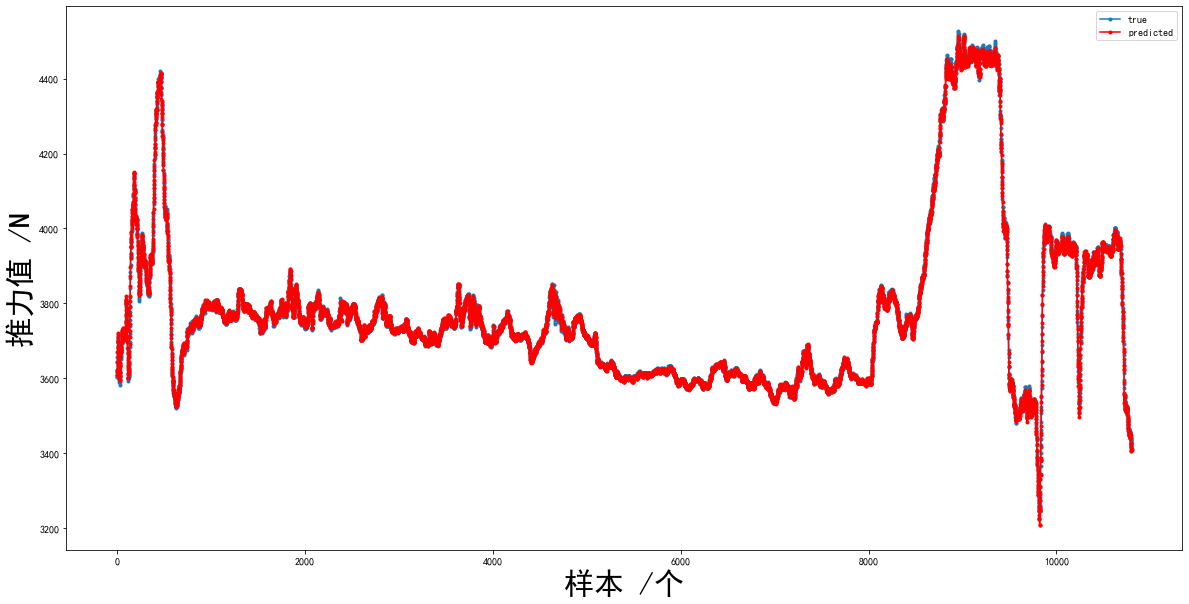

In [38]:
plt.figure(figsize=(20,10))
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False
plt.xlabel('样本 /个',fontdict={ 'size'   : 30})
plt.ylabel('推力值 /N',fontdict={ 'size'   : 30})
plt.plot(trainY_1[200:11000],marker='.',label='true')
plt.plot(predict_1[200:11000],'r',marker='.',label='predicted')                  #sample的时刻是一致的
plt.legend();